In [1]:
import fermi.tipsh as tipsh
from fermi.skymap import imshow_mollweide, imshow_carree
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mmappickle.dict import mmapdict
from scipy.ndimage import gaussian_filter
import numpy
import math
import fermi.rl as rl
import time
import datetime

In [2]:
energy = '500-1000gev'
fits_root = 'fits_files'
fwer = 'uniform'
alpha = 1e-6
mode = 'wavelet'
now = datetime.date.today()

In [3]:
filename = f"{now}_{energy}_{fwer}_{alpha}_{mode}.mmdpickle"
filename

'2022-01-23_500-1000gev_uniform_1e-06_wavelet.mmdpickle'

In [4]:
m = mmapdict(filename)
#m.vacuum()

In [5]:
data_file = get_pkg_data_filename(f"{fits_root}/lat_source_zmax90_{energy}_ccube.fits")
point_model_file = get_pkg_data_filename(f"{fits_root}/{energy}_source_point_model_map.fits")
diffuse_model_file = get_pkg_data_filename(f"{fits_root}/{energy}_source_diffuse_model_map.fits")
galactic_model_file = get_pkg_data_filename(f"{fits_root}/{energy}_source_galactic_model_map.fits")
isotropic_model_file = get_pkg_data_filename(f"{fits_root}/{energy}_source_isotropic_model_map.fits")
#exp_file = get_pkg_data_filename(f"{fits_root}/lat_source_zmax90_{energy}_expcube.fits")

In [6]:
count_cube = fits.getdata(data_file, ext=0)
count_data = count_cube[0]
point_model = fits.getdata(point_model_file, ext=0)
diffuse_model = fits.getdata(diffuse_model_file, ext=0)
galactic_model = fits.getdata(galactic_model_file, ext=0)
isotropic_model = fits.getdata(isotropic_model_file, ext=0)
#exp_cube = fits.getdata(exp_file, ext=0)
#exposure = exp_cube[0]

(<Figure size 2160x1080 with 2 Axes>, <AxesSubplot:>)

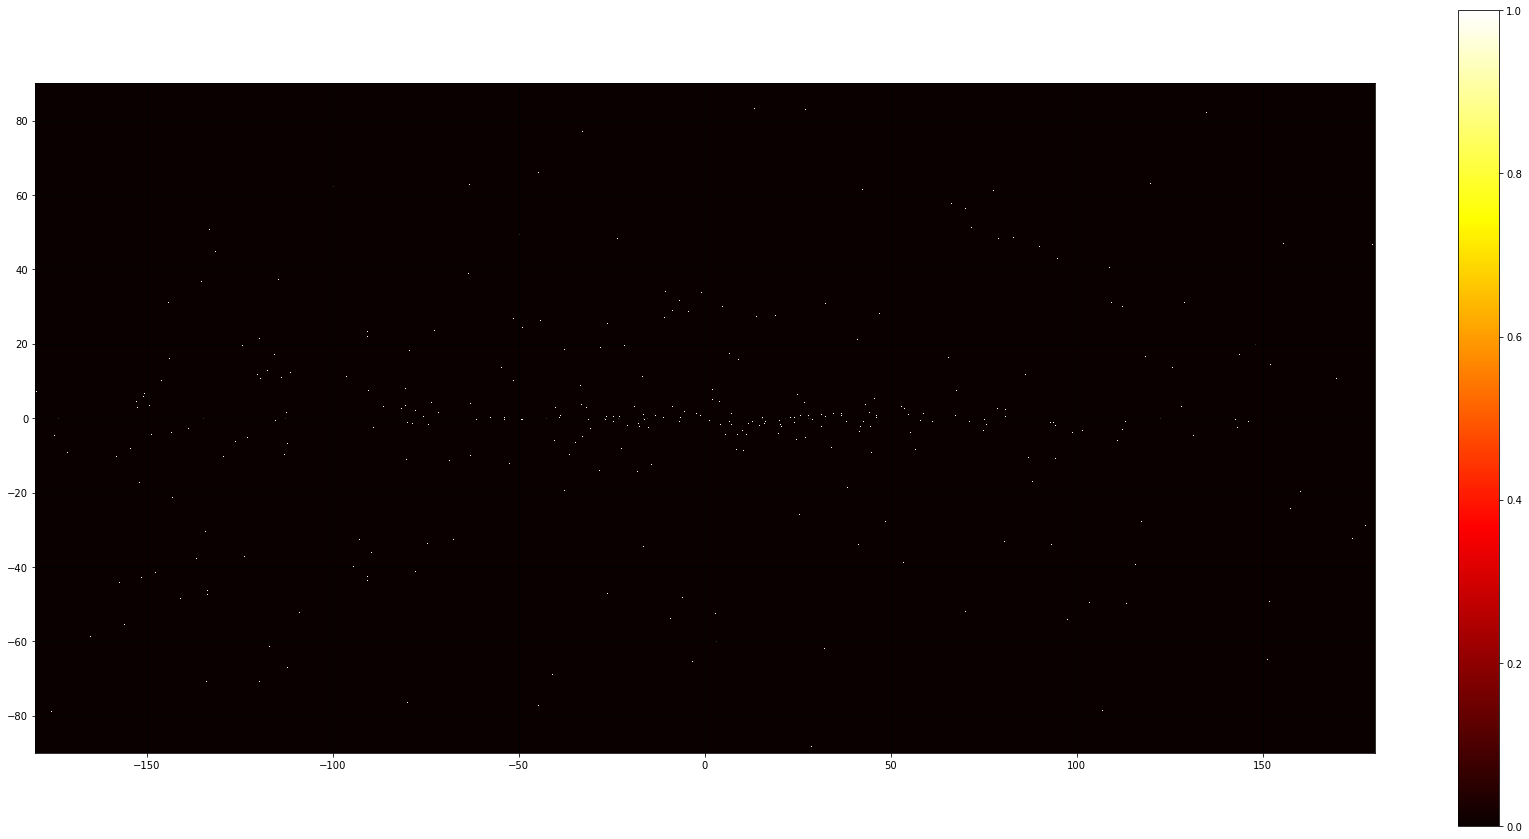

In [9]:
#tm = numpy.add(numpy.add(numpy.add(1.0*point_model, 1.0*diffuse_model), 1.0*galactic_model), 1.0*isotropic_model)
imshow_carree(count_data, plt.cm.hot, colors.Normalize(vmin=0,vmax=1e0), interpolation='none')

In [7]:
numpy.sum(count_data)

2340

(<Figure size 2160x1080 with 2 Axes>, <AxesSubplot:>)

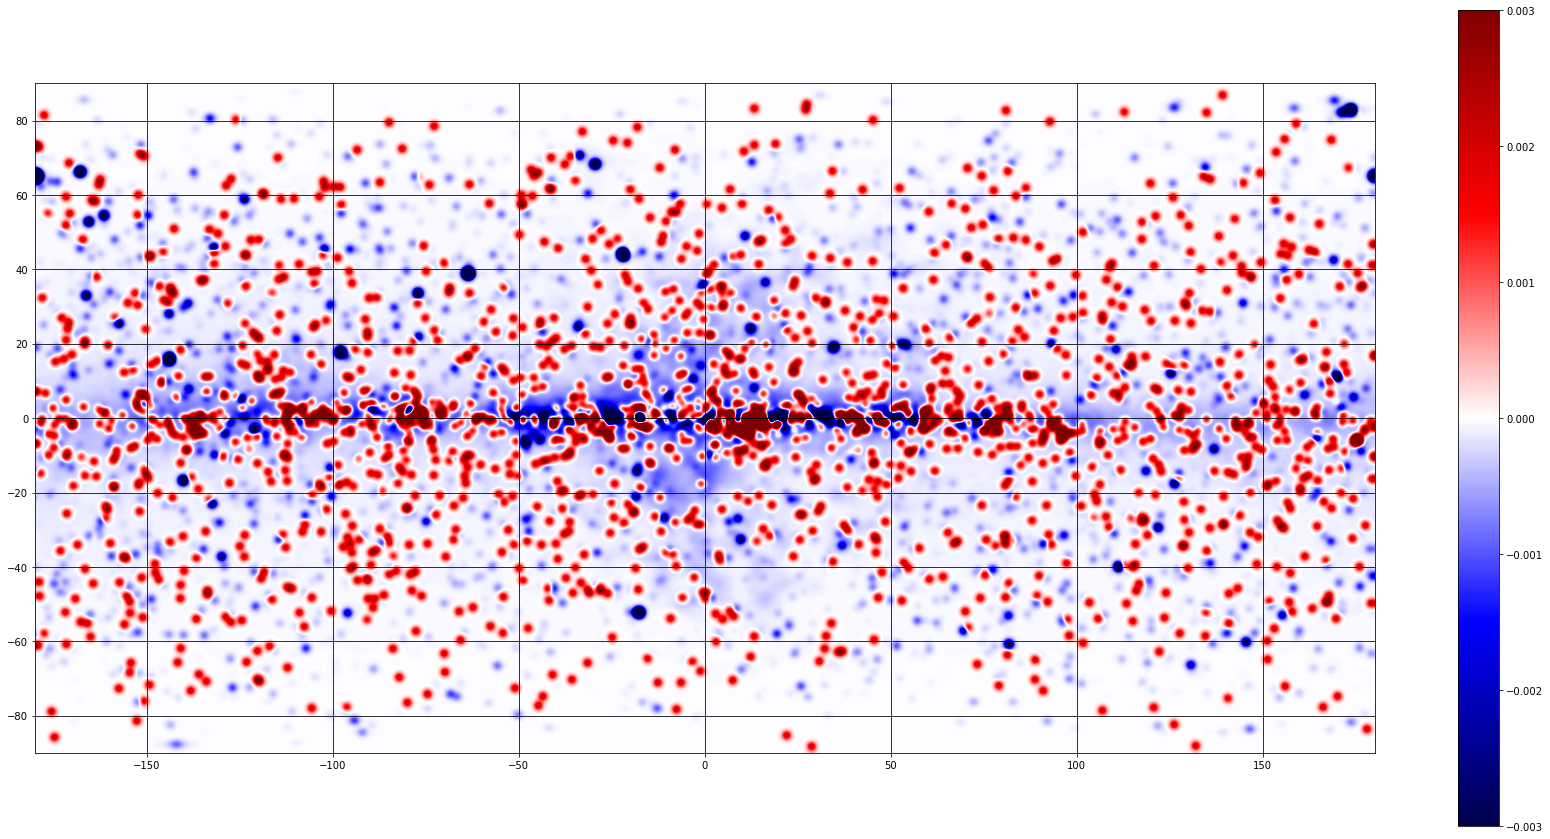

In [7]:
total_model = 1.0*point_model + 1.0*diffuse_model + 0.8*galactic_model + 1.0*isotropic_model
sigma = 8.45
#sigma = 20
imshow_carree(gaussian_filter(numpy.subtract(count_data, total_model), sigma), plt.cm.seismic, colors.Normalize(vmin=-3e-3,vmax=3e-3))

In [11]:
fig.savefig("nasa_10_20_GeV_fwhm_2deg.png")

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



In [13]:
# Run one iteration and write a profile stats file.
# make visualization with "make dot"

#import cProfile
#cProfile.run("tipsh.haar_threshold_sphere(count_data, total_model, 0.001, 11, fwer='uniform')", filename="fermi.pstats")

(<Figure size 2160x1080 with 2 Axes>, <AxesSubplot:>)

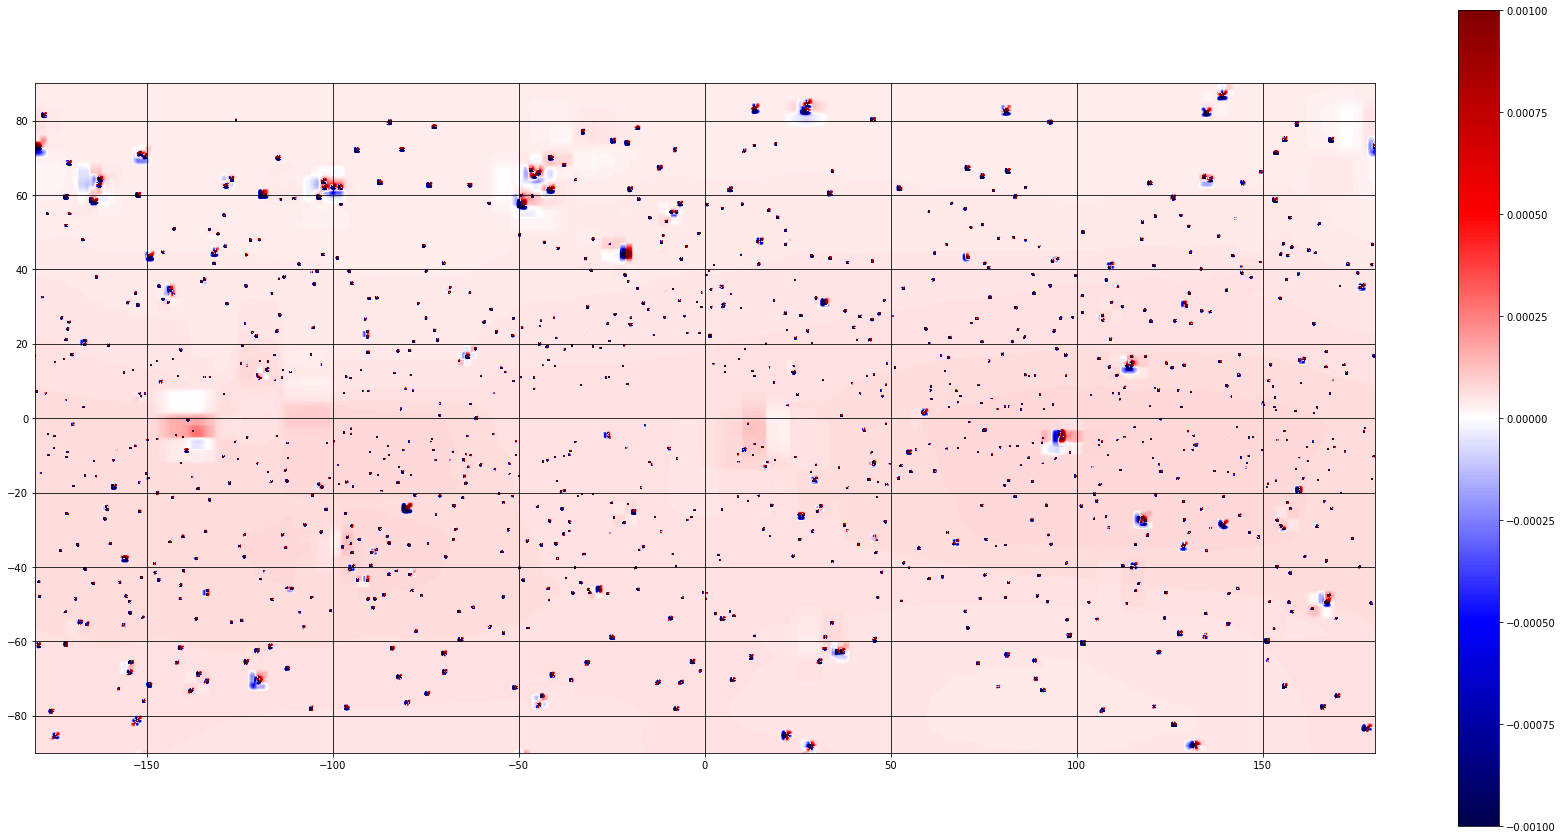

In [8]:
imshow_carree(m['count_rec'], plt.cm.seismic, colors.Normalize(vmin=-1e-3,vmax=1e-3))

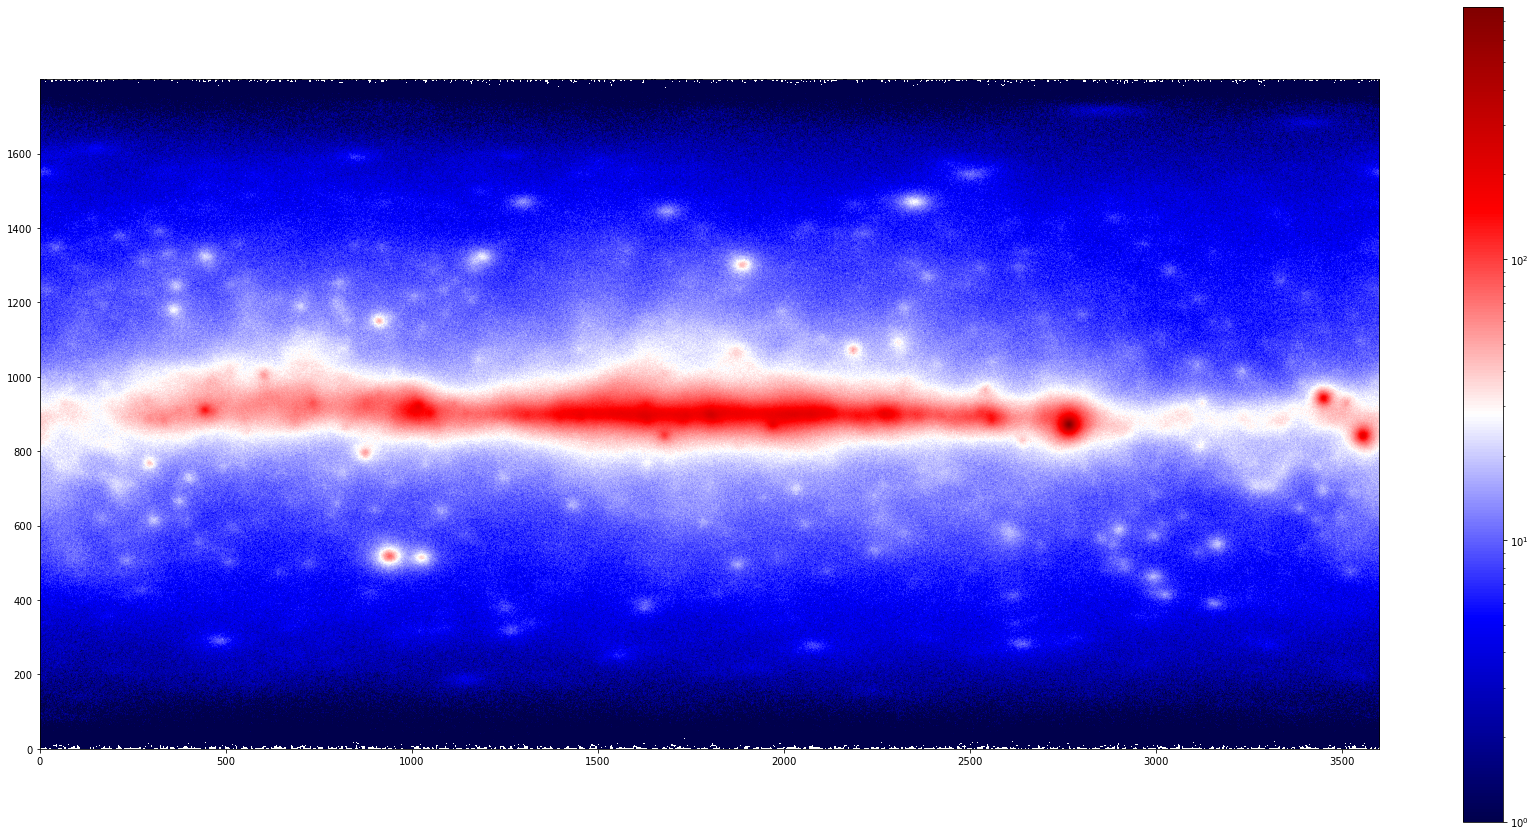

In [27]:
fig = plt.figure(figsize=(30, 15))
ax = plt.subplot()
foo = plt.imshow(count_data, cmap=plt.cm.seismic, norm=colors.LogNorm(), origin='lower')
plt.colorbar(foo)

(<Figure size 2160x1080 with 2 Axes>, <GeoAxesSubplot:>)

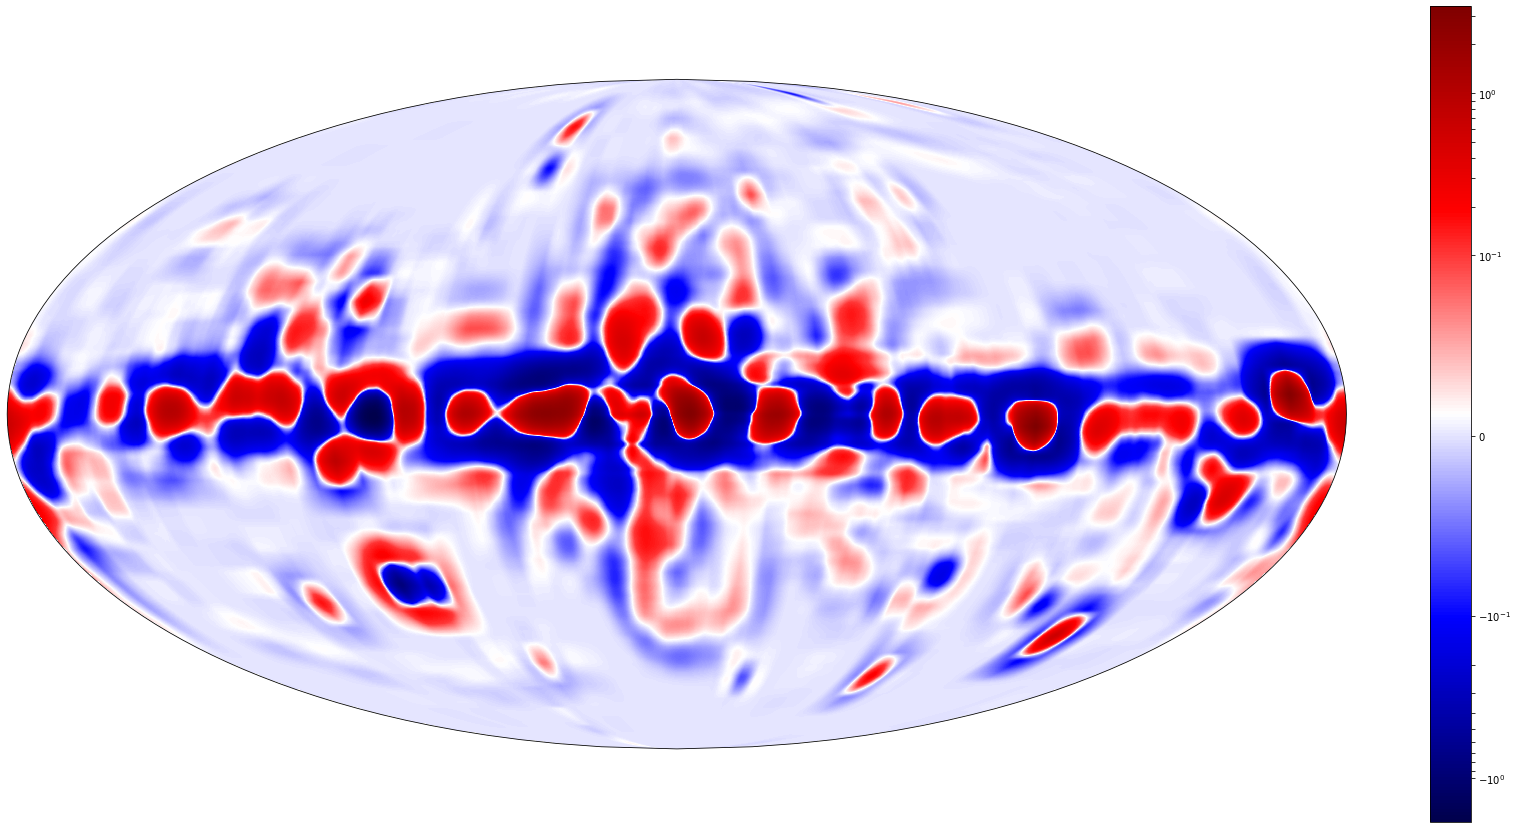

In [40]:
rlev = tipsh.inv_haar_level(7, a, hs, vs, ds)
imshow_mollweide(rlev, plt.cm.seismic, colors.SymLogNorm(linthresh=1e-1))

/home/dave/anaconda3/envs/fermi/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dave/anaconda3/envs/fermi/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


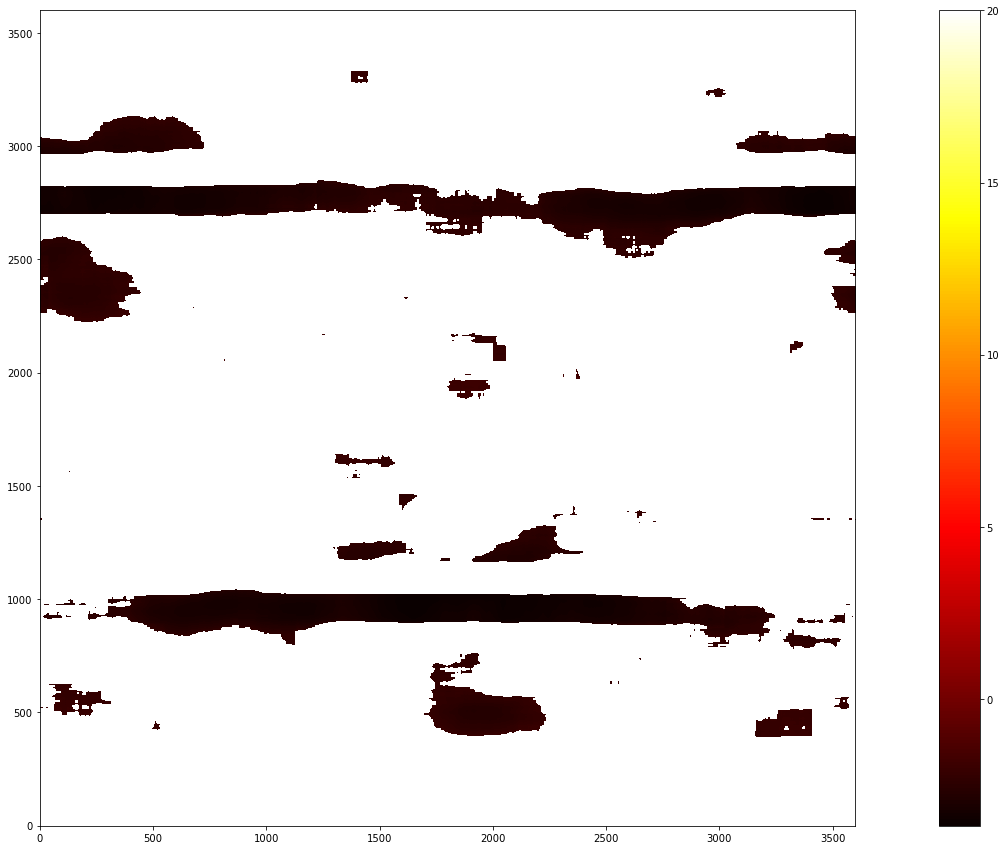

In [22]:
fig = plt.figure(figsize=(30, 15))
ax = plt.subplot()
foo = plt.imshow(-numpy.log10(vs[7]), cmap=plt.cm.hot, norm=colors.Normalize(vmax=20), origin='lower')
plt.colorbar(foo)

In [9]:
fig.savefig("2022-01-03_10_20_GeV_sidak_01.png")

In [25]:
lon = numpy.arange(-180, 180, 0.1)
lat = numpy.arange(-90, 90, 0.1)
Lat, Lon = numpy.meshgrid(lon, lat)
levels = numpy.arange(-0.1, 0.1, 0.01)

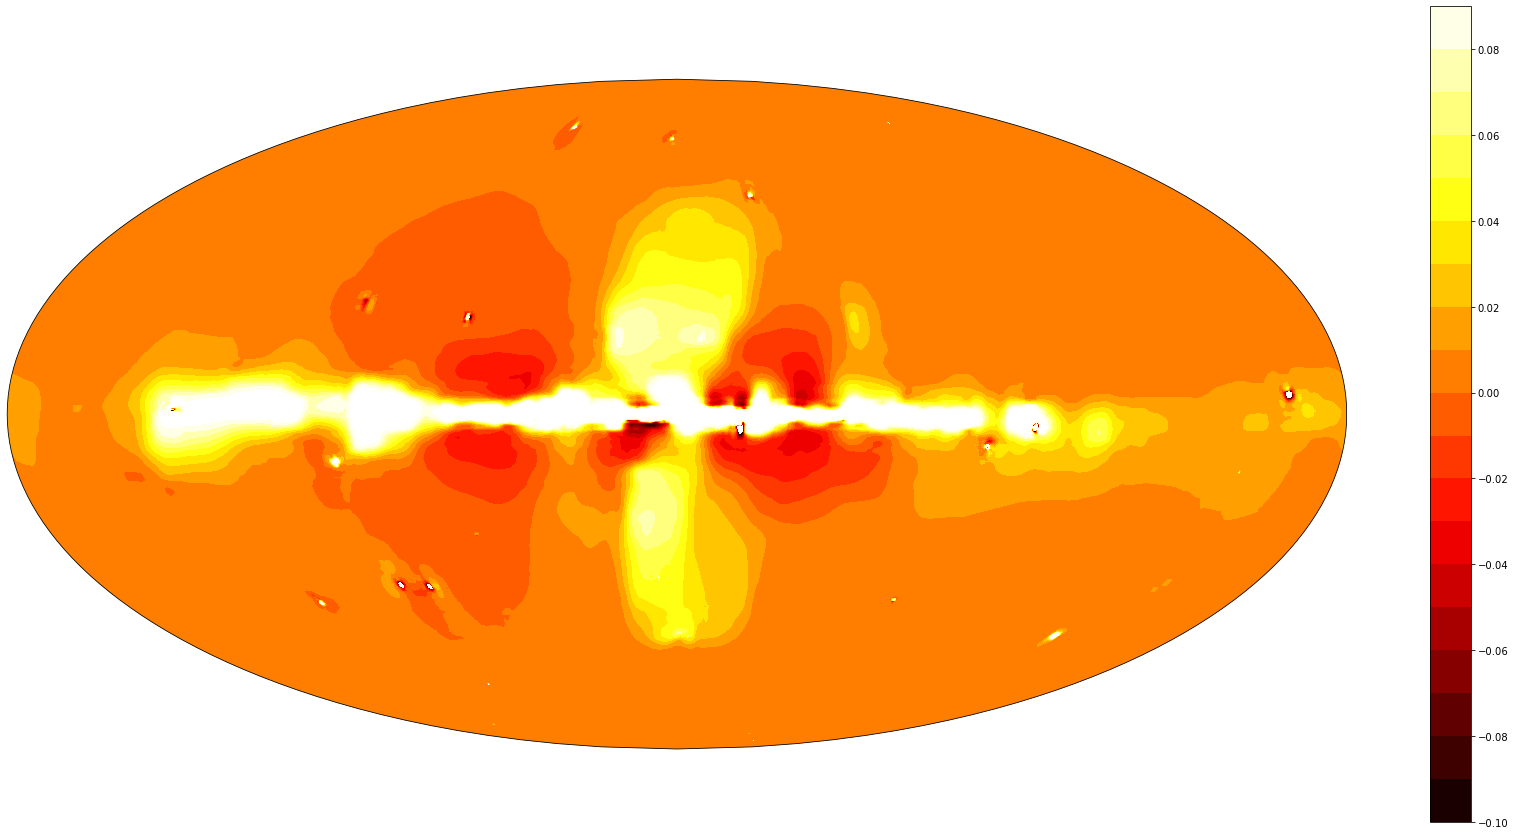

In [26]:
fig = plt.figure(figsize=(30, 15))
ax = plt.subplot(projection=ccrs.Mollweide())
foo = plt.contourf(Lat, Lon, numpy.subtract(count_rec, total_model), levels, cmap=plt.cm.hot, linewidths=0.3, transform=ccrs.PlateCarree())
plt.colorbar(foo)

(array([5.979595e+06, 4.140870e+05, 7.005200e+04, 9.642000e+03,
        3.416000e+03, 1.417000e+03, 1.102000e+03, 2.700000e+02,
        1.220000e+02, 2.070000e+02, 4.100000e+01, 1.000000e+01]),
 array([  0,   1,   2,   4,   6,   8,  10,  15,  20,  25,  50,  75, 100]),
 <BarContainer object of 12 artists>)

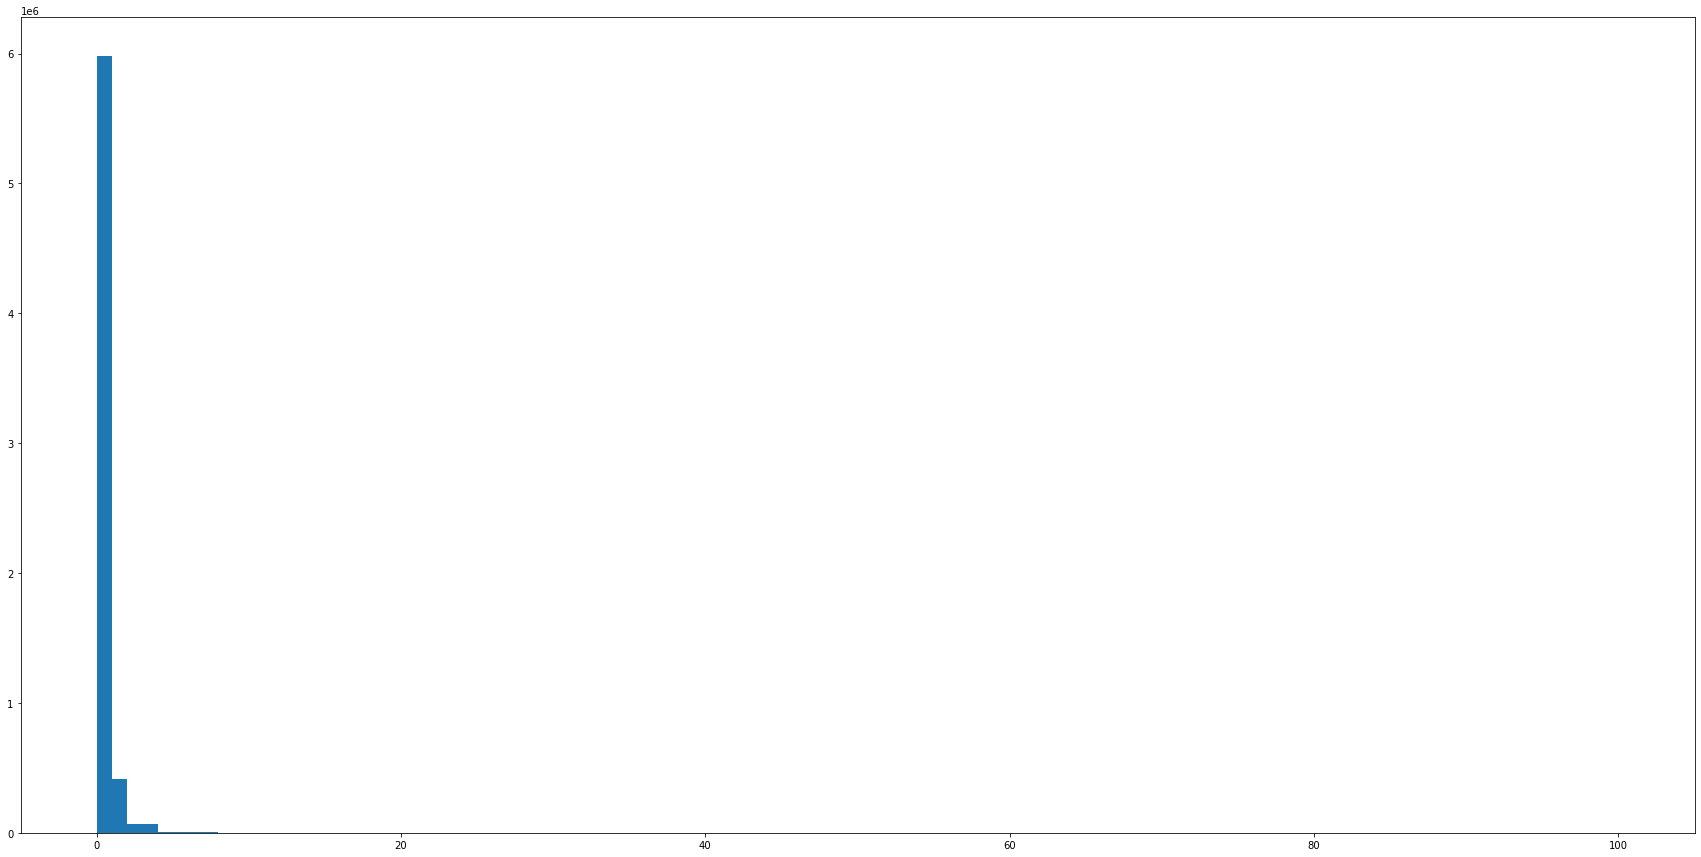

In [50]:
fig = plt.figure(figsize=(30, 15))
plt.hist(count_data.flat, bins=[0,1,2,4,6,8,10,15,20,25,50,75,100])

In [2]:
def zero(n):
    return numpy.zeros((n,n), float)

def checkers(n, p):
    arr = numpy.zeros((n, 2*n), float) + 2
    for row in range(n):
        rq, rr = divmod(row, p)
        row_mult = 1 if rq % 2 == 0 else -1
        for col in range(2*n):
            cq, cr = divmod(col, p)
            col_mult = 1 if cq % 2 == 0 else -1
            arr[row,col] += row_mult*col_mult
    return arr

def delta(n, row, col):
    arr = numpy.zeros((n, 2*n), float) 
    arr[row, col] = 1
    return arr

def stripe(n, rows):
    arr = numpy.zeros((n, 2*n), float) 
    arr[rows, :] = 1
    return arr

In [3]:
#total_model = stripe(30, [13,14,15])*10 + 1
#data_model = 0.225*count_model #+ stripe(30, [13,14,15])*10 #+ 20*delta(30, 15, 15)
#count_data = poisson.rvs(data_model)
#a_model, hs_model, vs_model, ds_model = haar(count_model)
#a_data, hs_data, vs_data, ds_data = haar(count_data)